In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import japanize_matplotlib

# データ読み込み

In [2]:
df = pd.read_csv("btf_periods900.csv")
df["CloseTime"] = df["CloseTime"].apply(dt.datetime.fromtimestamp)

FileNotFoundError: [Errno 2] No such file or directory: 'btf_periods900.csv'

In [3]:
df

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,QuoteVolume
0,2023-01-27 06:45:00,3002059,3005999,2999462,3002677,11.104998,3.334829e+07
1,2023-01-27 07:00:00,3002677,3005400,3002677,3005233,1.200600,3.607687e+06
2,2023-01-27 07:15:00,3005233,3014000,3003500,3005769,14.542887,4.372777e+07
3,2023-01-27 07:30:00,3006506,3007610,3000472,3002485,5.748022,1.726347e+07
4,2023-01-27 07:45:00,3000720,3002001,2998195,2998195,1.606233,4.818659e+06
...,...,...,...,...,...,...,...
6067,2023-03-31 12:15:00,3737777,3746704,3737777,3746000,17.893178,6.694218e+07
6068,2023-03-31 12:30:00,3746000,3753323,3743091,3753322,20.142798,7.547096e+07
6069,2023-03-31 12:45:00,3753325,3755233,3748641,3750538,24.094955,9.039643e+07
6070,2023-03-31 13:00:00,3750586,3751051,3746585,3746801,15.904765,5.962405e+07


# Exploratory Data Analysis

- 手数料は(直近30日の取引量が10万円以下の場合)0.15%.
  - https://bitflyer.com/ja-jp/s/commission
- 売り買いで2回手数料がかかることに注意
- 短期のトレードで、手数料込みでどのくらい勝てるかを検証

## 買って15分後に売る戦略

In [4]:
df = pd.read_csv("btf_periods900.csv")
df["CloseTime"] = df["CloseTime"].apply(dt.datetime.fromtimestamp)
fee_rate = 0.15 / 100

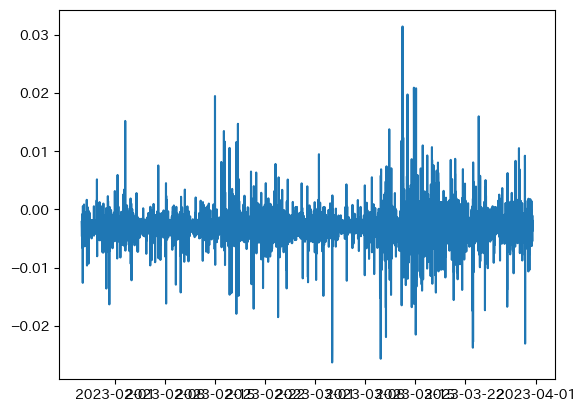

In [5]:
time = df["CloseTime"].values
# 現在時刻で買い、1期先に売ったときのリターン
df["return_1"] = (df["ClosePrice"].shift(-1) * (1 - fee_rate) - df["ClosePrice"] * (1 + fee_rate)) / df["ClosePrice"]
fig, ax = plt.subplots()
ax.plot(time, df["return_1"])

The number of profit opportunities: 460/6072


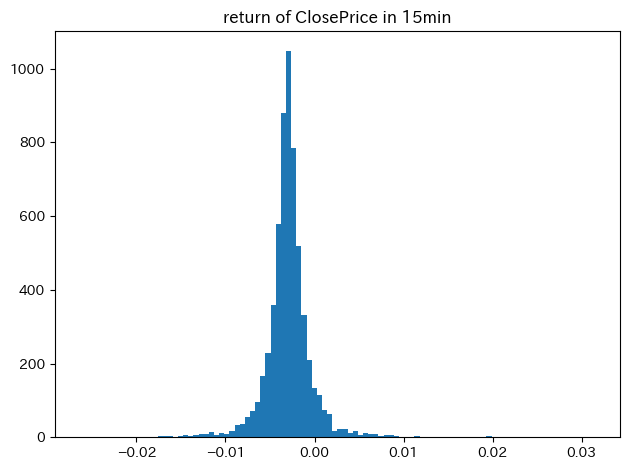

In [6]:
fig, ax = plt.subplots()
ax.hist(df["return_1"], bins=100)
ax.set_title("return of ClosePrice in 15min")
print(f'The number of profit opportunities: {len(df[df["return_1"] > 0])}/{len(df)}')
fig.tight_layout()

結論: 10回に1回しか勝てないので、分が悪そう

# 買って15*n分後に売る戦略

In [7]:
df = pd.read_csv("btf_periods900.csv")
df["CloseTime"] = df["CloseTime"].apply(dt.datetime.fromtimestamp)
fee_rate = 0.15 / 100
period = 3  

The number of profit opportunities: 992/6072


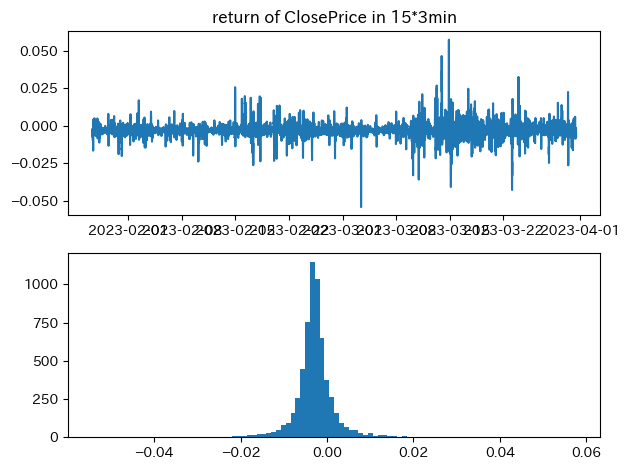

In [8]:
time = df["CloseTime"].values
# 現在時刻で買い、period期先に売ったときのリターン
df[f"return_{period}"] = (df["ClosePrice"].shift(-period) * (1 - fee_rate) - df["ClosePrice"] * (1 + fee_rate)) / df["ClosePrice"]
fig, axes = plt.subplots(2, 1, tight_layout=True)
axes[0].plot(time, df[f"return_{period}"])
axes[0].set_title(f"return of ClosePrice in 15*{period}min")
axes[1].hist(df[f"return_{period}"], bins=100)
print(f'The number of profit opportunities: {len(df[df[f"return_{period}"] > 0])}/{len(df)}')

In [9]:
l = []
for period in range(1, 100):
    time = df["CloseTime"].values
    # 現在時刻で買い、period期先に売ったときのリターン
    df[f"return_{period}"] = (df["ClosePrice"].shift(-period) * (1 - fee_rate) - df["ClosePrice"] * (1 + fee_rate)) / df["ClosePrice"]
    num_of_win = len(df[df[f"return_{period}"] > 0])
    l.append(num_of_win)

Text(0.5, 0, '何期後にポジション解消するか')

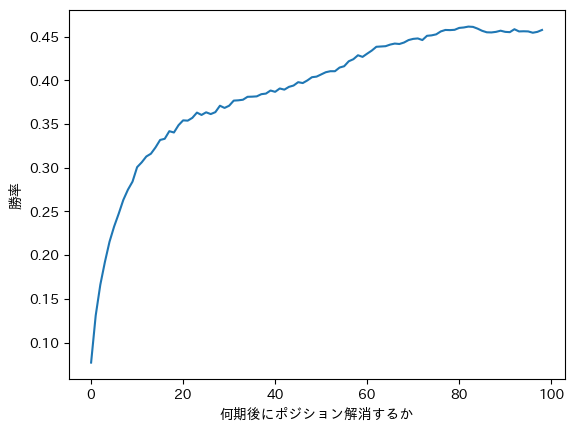

In [13]:
plt.plot(np.array(l) / len(df.dropna()))
plt.ylabel("勝率")
plt.xlabel("何期後にポジション解消するか")

# 結論
- 単純に買って売るだけだと負けるので、何かのインジケーターを参照して売買する必要がある。